<!--NAVIGATION-->

<a href="https://colab.research.google.com/github/bpesquet/machine-learning-katas/blob/master/notebooks/demos/algorithms/DNN_Tuning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# Neural Networks Tuning

## Package setup

In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.datasets import imdb

# Display plots inline, change default figure size and change plot resolution to retina
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 8]
%config InlineBackend.figure_format = 'retina'
# Set Seaborn aesthetic parameters to defaults
sns.set()

## Utility functions

In [37]:
def plot_data(X, y):
    """Plot some data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ob', alpha=0.5, label=1)
    plt.legend()


def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['acc']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_acc' in history.history:
        val_acc = history.history['val_acc']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()
    

def vectorize_sequences(sequences, dimension=10000):
    """One-hot encode a vector of sequences into a binary matrix (number of sequences, dimension)"""
    
    # Example : [[3, 5]] -> [[0. 0. 0. 1. 0. 1. 0...]]
    
    results = np.zeros((len(sequences), dimension))
    # set specific indices of results[i] to 1s
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

## Observing underfitting and overfitting

Inspired by [this article](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/).

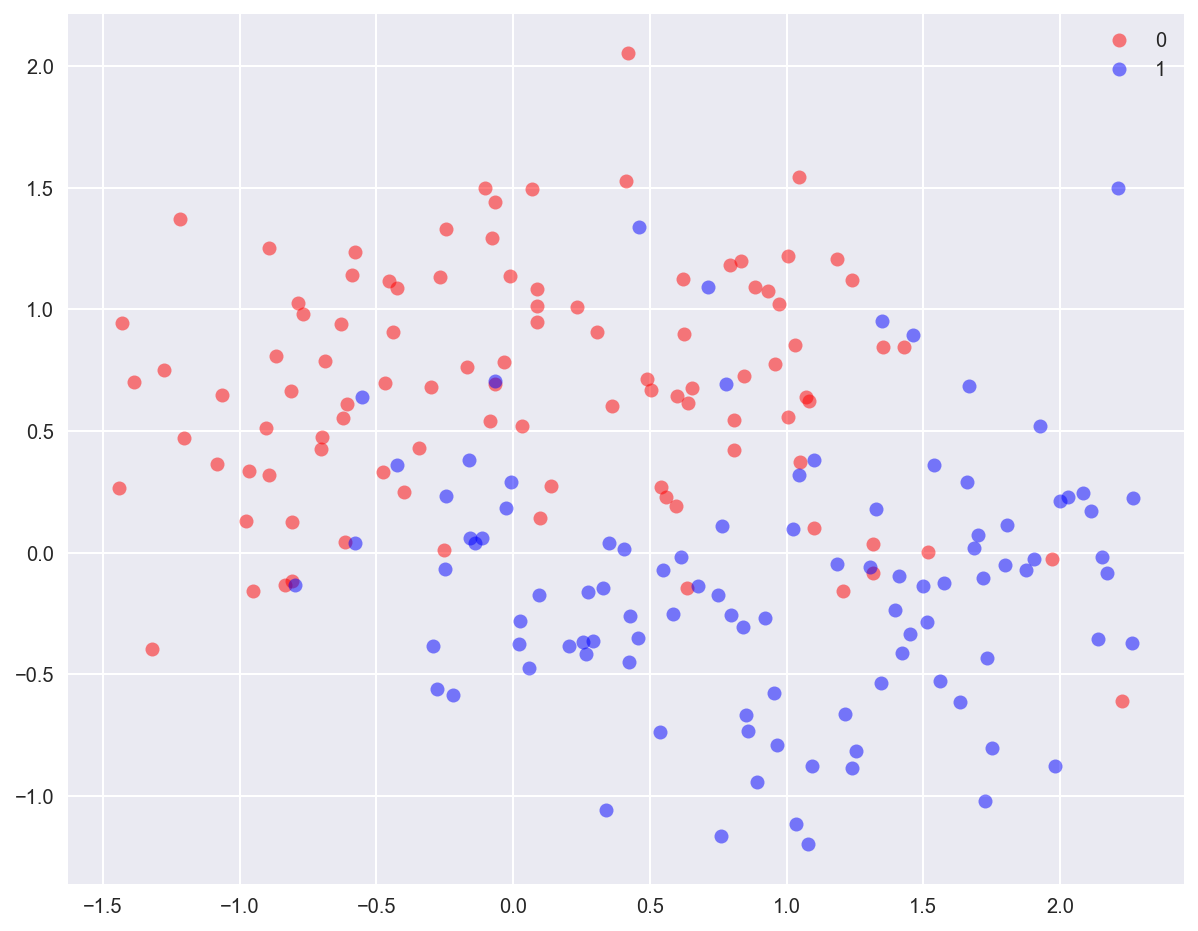

In [38]:
# Generate moon-shaped data with some noise
x_train, y_train = make_moons(200, noise=0.40)

plot_data(x_train, y_train)

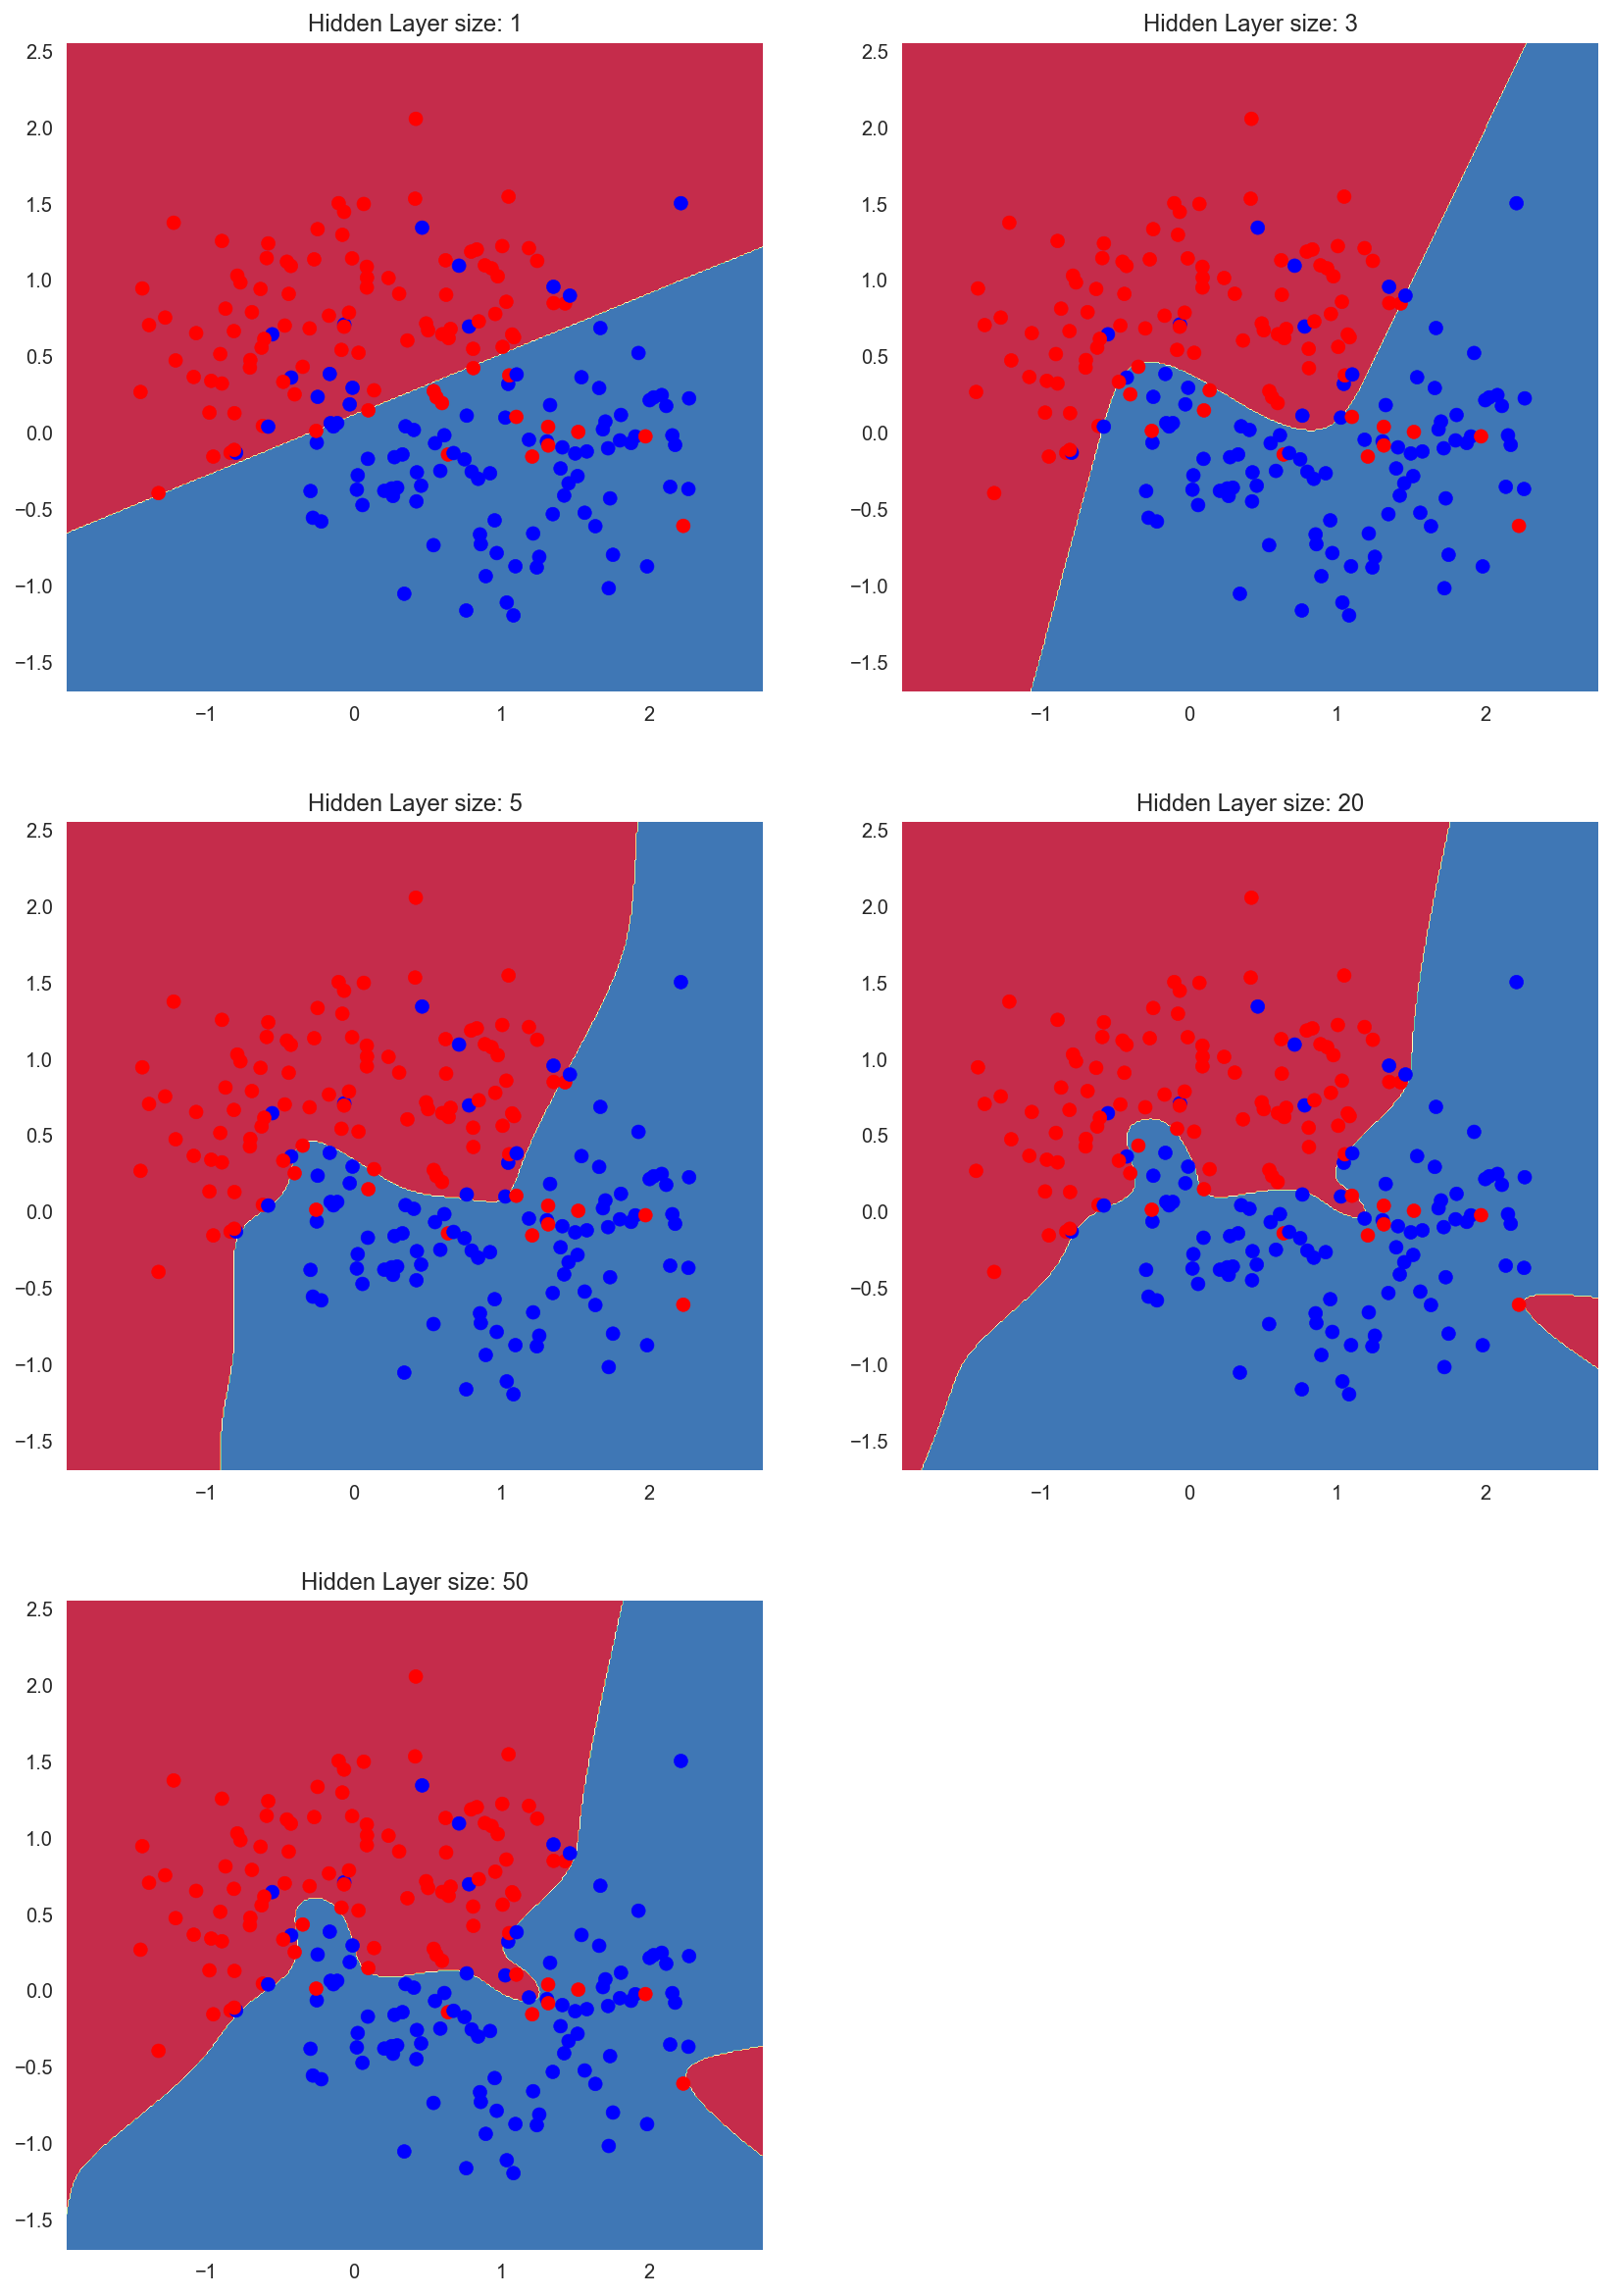

In [39]:
# Varying the hidden layer size to observe underfitting and overfitting

plt.figure(figsize=(14, 28))
hidden_layer_dimensions = [1, 3, 5, 20, 50]
for i, hidden_layer_size in enumerate(hidden_layer_dimensions):
    fig = plt.subplot(4, 2, i+1)
    plt.title('Hidden Layer size: {:d}'.format(hidden_layer_size))
    
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation='tanh', input_shape=(2,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
    # Batch size = dataset size => batch gradient descent
    history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

    plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train, fig)

## Tackling overfitting

### Regularization

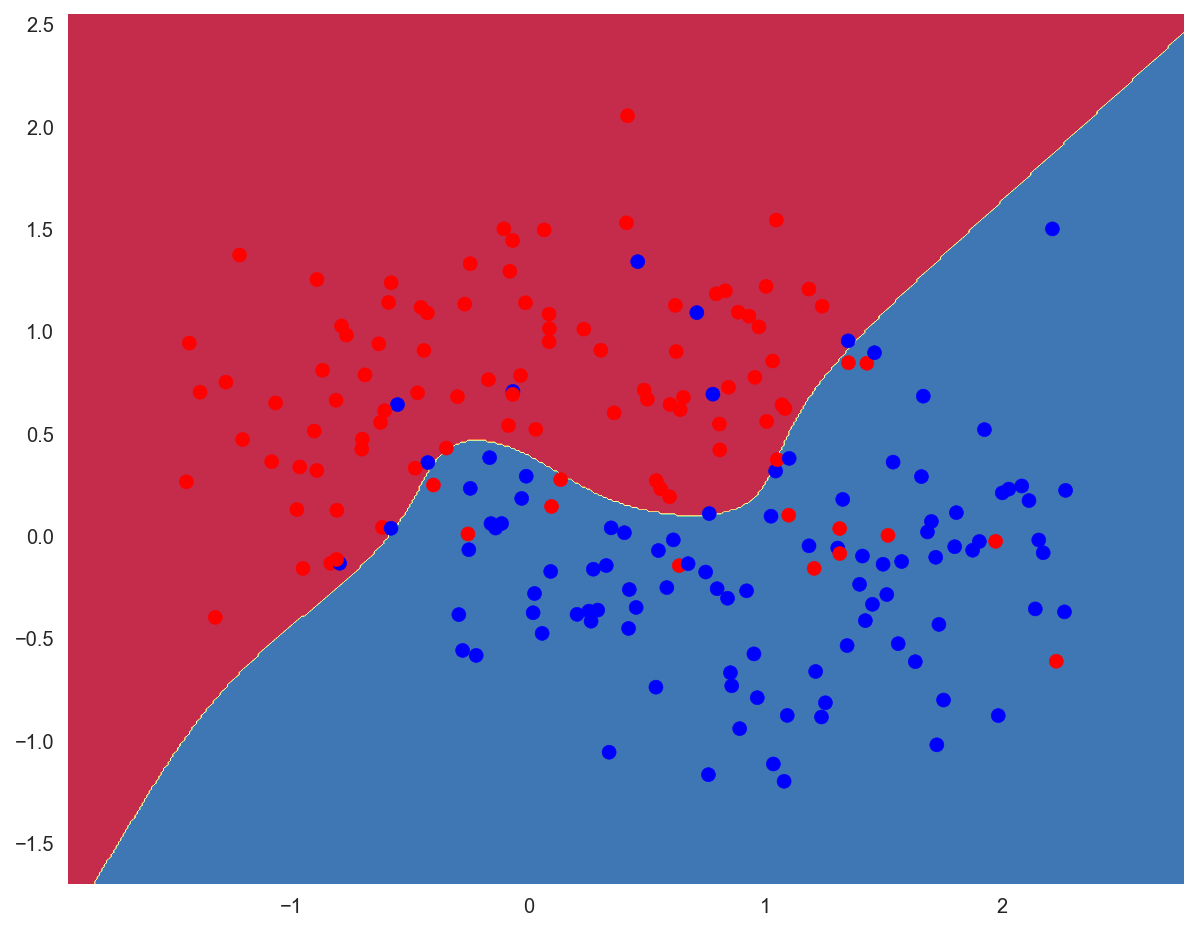

In [40]:
model = Sequential()
# Use L1 regularization on hidden layer
model.add(Dense(50, activation='tanh', input_shape=(2,), 
                kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
# Batch size = dataset size => batch gradient descent
history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train)

### Dropout

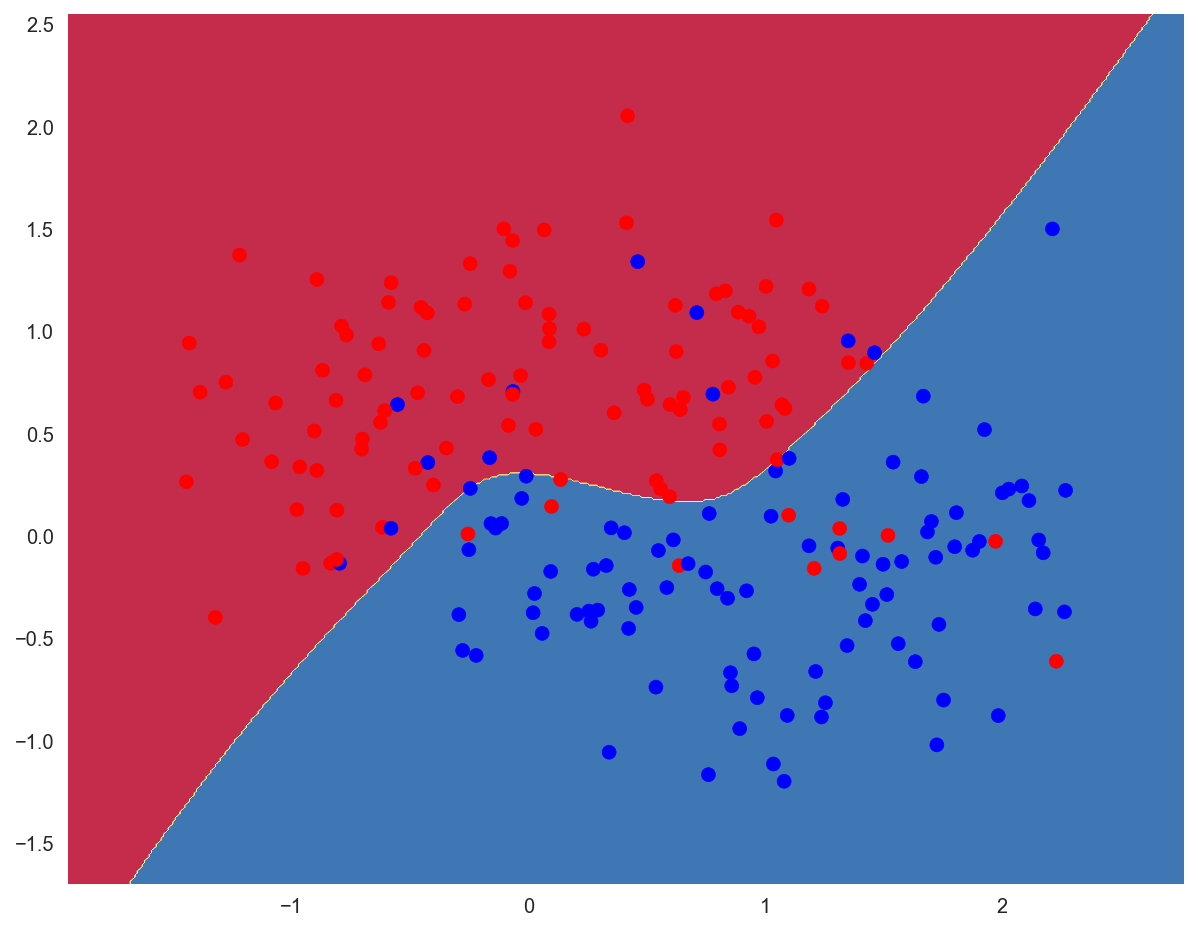

In [41]:
model = Sequential()
# Use 25% dropout on hidden layer
model.add(Dense(50, activation='tanh', input_shape=(2,)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
# Batch size = dataset size => batch gradient descent
history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train)

## Overfitting on a real-world example

Inspired by a use case in François Chollet's book [Deep Learning With Python](https://www.manning.com/books/deep-learning-with-python).

In [42]:
# Load the Keras IMDB dataset
# We only keep the top 10,000 most frequently occuring words in the training data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print(f'Training data: {train_data.shape}. Training labels: {train_labels.shape}')

# Reviews are encoded as lists of word indexes
# Words are indexed by overall frequency in the dataset
print(f'First review: {train_data[0]}')

# Labels are binary integers: 0 for a negative review, 1 for a positive one
print(f'First label: {train_labels[0]}')

Training data: (25000,). Training labels: (25000,)
First review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,

In [43]:
# Show the first review as text

# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [44]:
# Preparation of data for training

# Turn reviews into vectors of 0s and 1s (one-hot encoding)
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Set apart the first 10,000 reviews as validation data
x_val, x_train = x_train[:10000], x_train[10000:]
y_val, y_train = train_labels[:10000], train_labels[10000:]

y_test = test_labels

print(f'x_train: {x_train.shape}. x_val: {x_val.shape}')

x_train: (15000, 10000). x_val: (10000, 10000)


In [45]:
# Show a sample of encoded input
df_x_train = pd.DataFrame(x_train)
df_x_train.sample(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
1908,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11016,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11869,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12335,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12918,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
522,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14298,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13054,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6184,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_57 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 211us/step - loss: 0.5189 - acc: 0.7880 - val_loss: 0.4059 - val_acc: 0.8620
Epoch 2/20
15000/15000 [==============================] - 2s 129us/step - loss: 0.3146 - acc: 0.9018 - val_loss: 0.3124 - val_acc: 0.8851
Epoch 3/20
15000/15000 [==============================] - 2s 130us/step - 

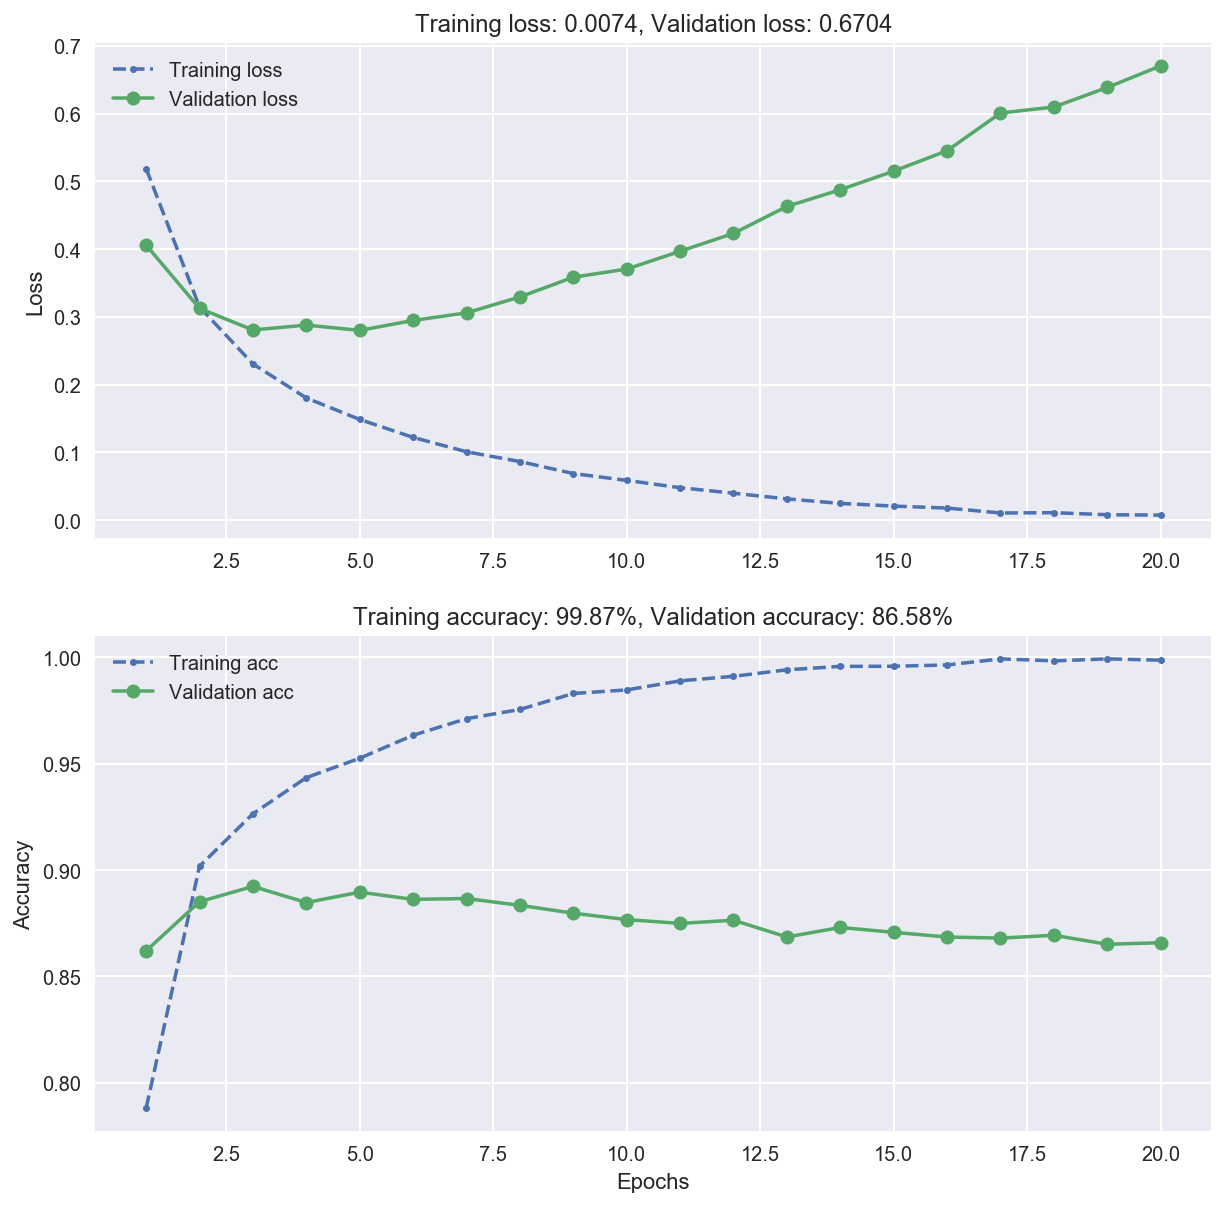

In [46]:
# Build a (10000, 16, 16, 1) NN to demonstrate overfitting
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# We also record validation history during training
history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

In [47]:
# Evaluate model performance on test data
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f'Test accuracy: {test_acc * 100}%')

25000/25000 [==============================] - 3s 117us/step
Test accuracy: 85.096%


### Reducing network size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_60 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 193us/step - loss: 0.6182 - acc: 0.6648 - val_loss: 0.5723 - val_acc: 0.8335
Epoch 2/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.5181 - acc: 0.8131 - val_loss: 0.5107 - val_acc: 0.8424
Epoch 3/20
15000/15000 [==============================] - 2s 127us/step - lo

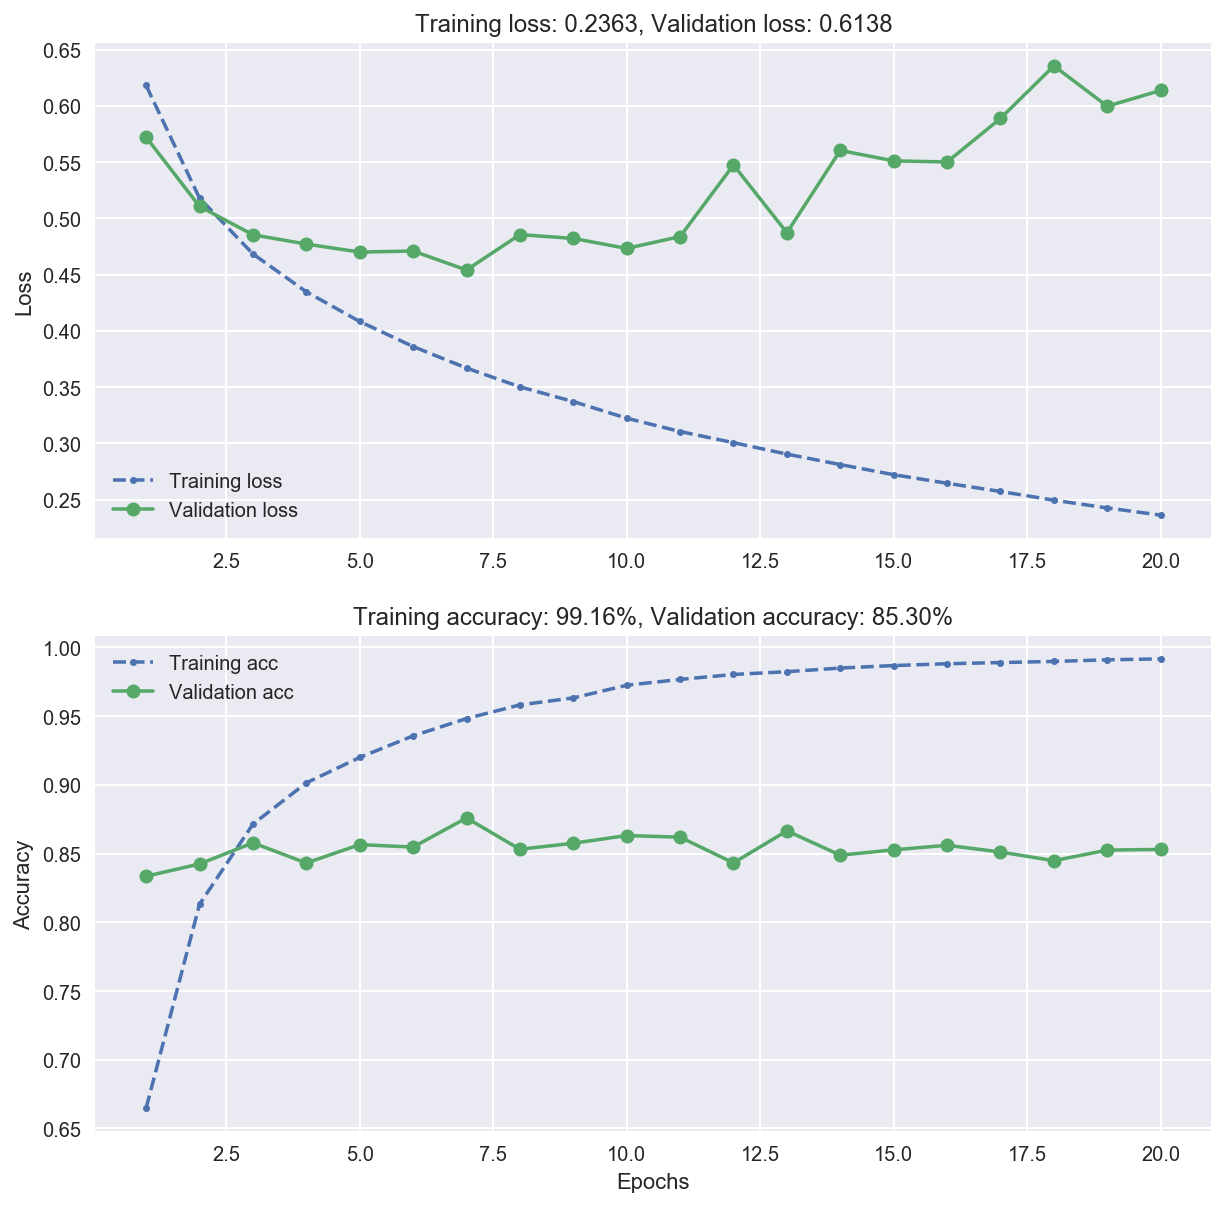

In [48]:
# Build and train a smaller network
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Show model info to check the new number of parameters
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

### Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 175us/step - loss: 0.5716 - acc: 0.7734 - val_loss: 0.4639 - val_acc: 0.8651
Epoch 2/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.3941 - acc: 0.8941 - val_loss: 0.3775 - val_acc: 0.8825
Epoch 3/20
15000/15000 [==============================] - 2s 124us/step - lo

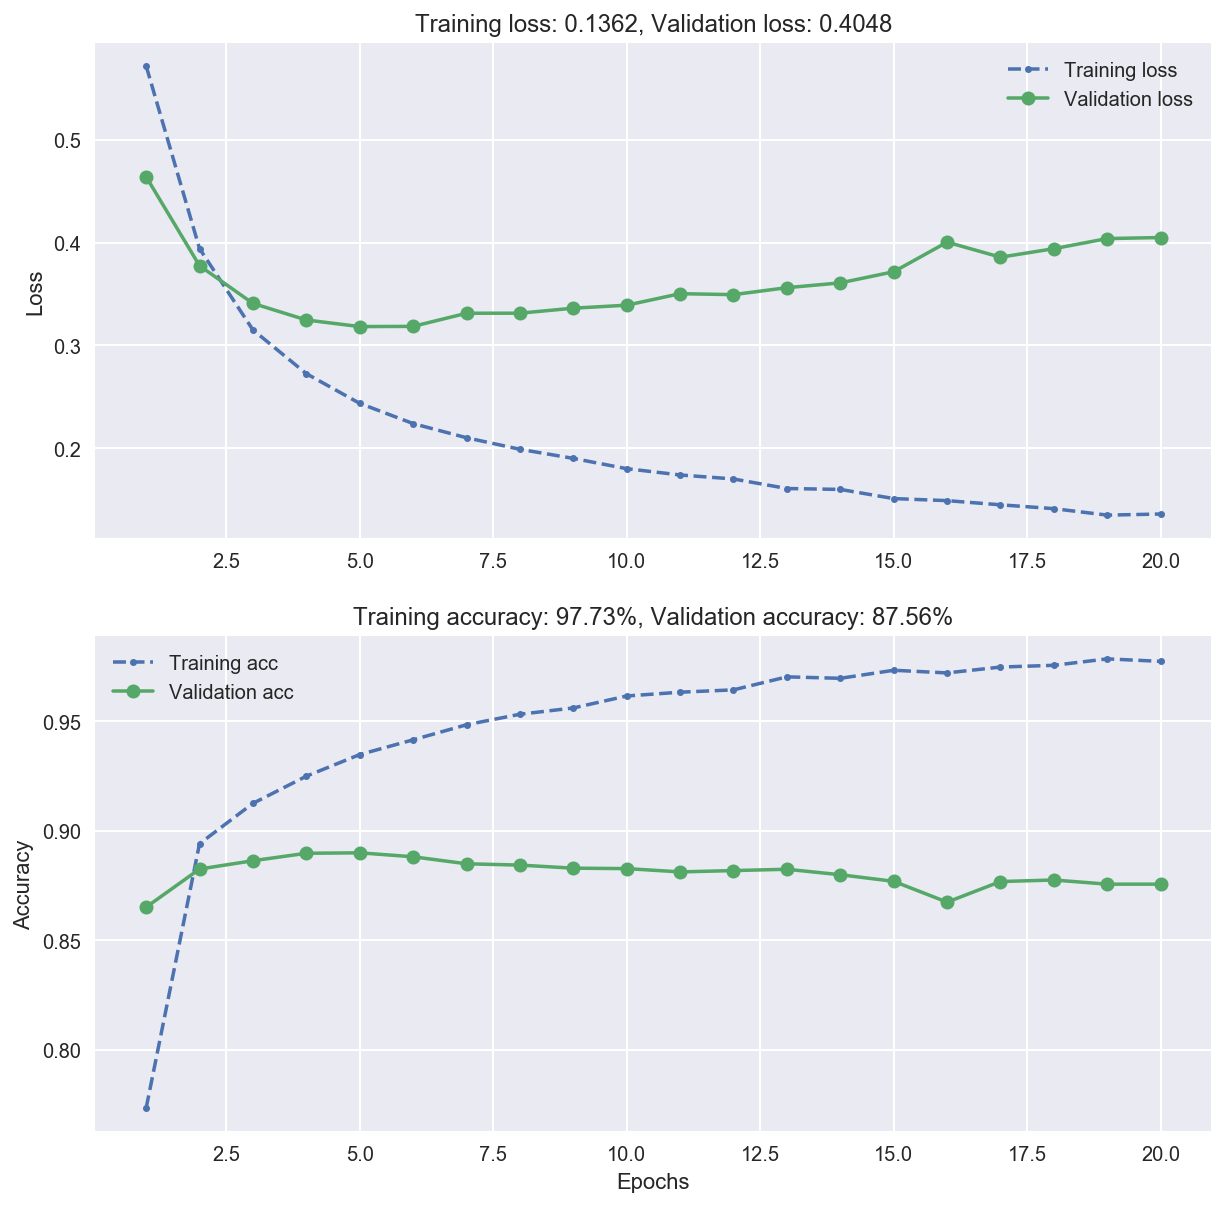

In [49]:
# Create the same model as before but now using L2 regularization
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

### Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 181us/step - loss: 0.6768 -

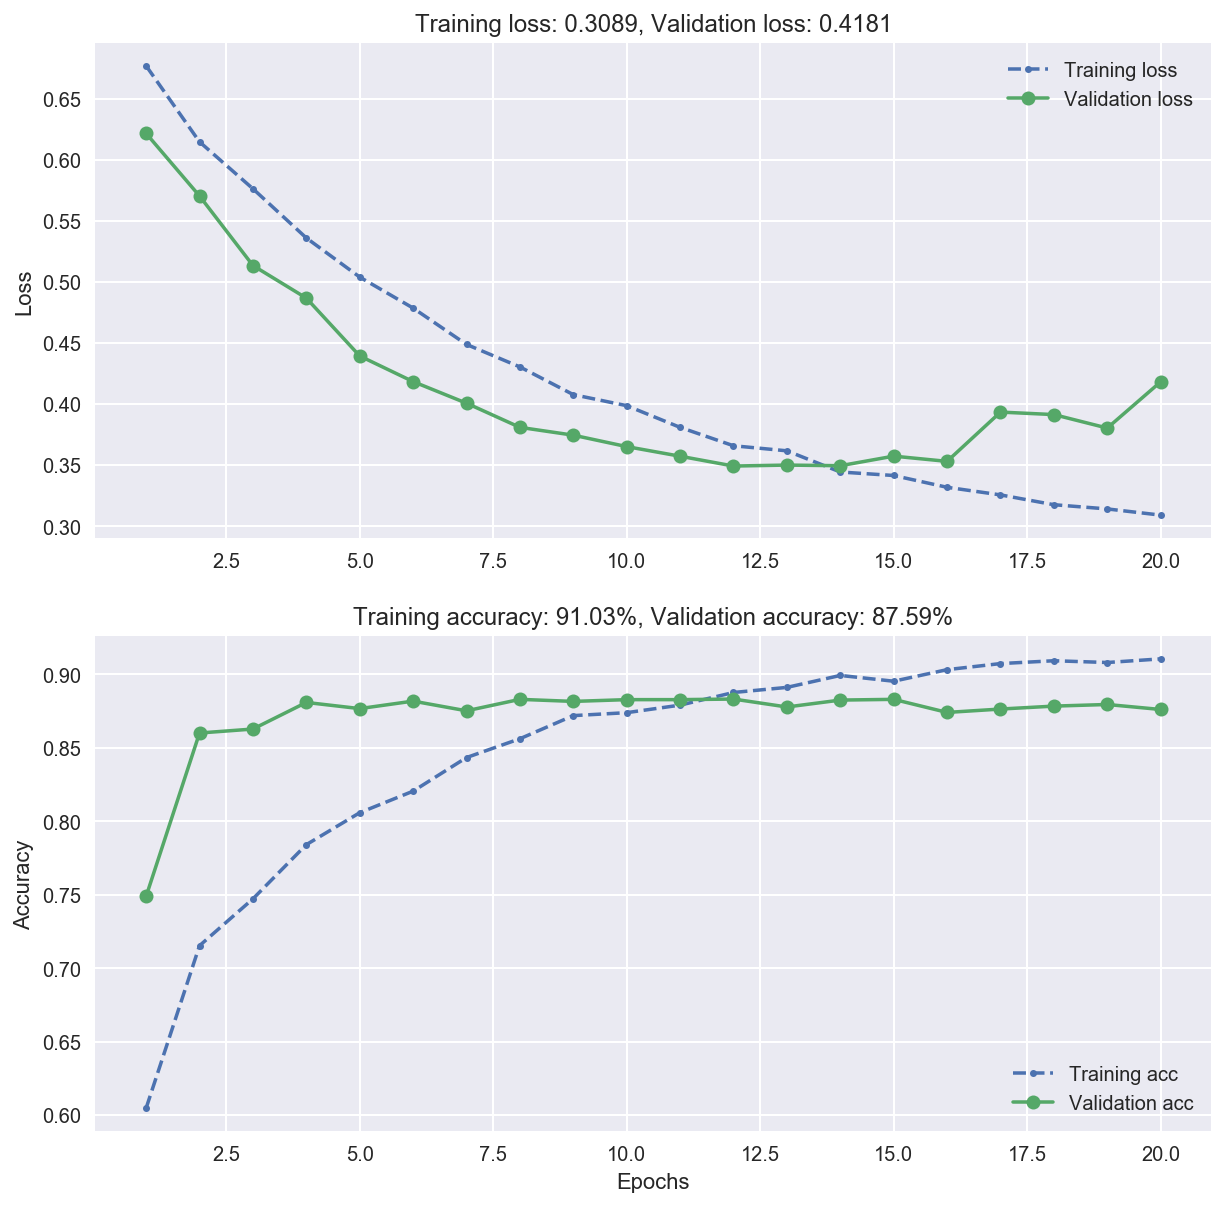

In [50]:
# Add 50% dropout to the two hidden layers
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

In [51]:
# Evaluate tuned model performance on test data
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f'Test accuracy: {test_acc * 100}%')

25000/25000 [==============================] - 4s 140us/step
Test accuracy: 86.94800000000001%
